In [1]:
import os
import cv2 as cv
from tqdm import tqdm

# data
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt


2025-01-01 19:07:43.589895: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 19:07:43.599195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 19:07:43.610465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 19:07:43.613688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 19:07:43.622166: I tensorflow/core/platform/cpu_feature_guar

# **Data**

In [2]:
%load_ext autoreload
%autoreload 2
from utils import show_image

/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
image_path = 'data/Water Bodies Dataset/Images/'
mask_path = 'data/Water Bodies Dataset/Masks/'

if os.path.exists(image_path) and os.path.exists(mask_path):
    image_names = sorted(os.listdir(image_path))
    mask_names = sorted(os.listdir(mask_path))

    num_images = len(image_names)
    num_masks = len(mask_names)

    image_mask_match = "Si" if image_names == mask_names else "No"

    print(f"Cantidad de imagenes: {num_images}")
    print(f"Cantidad de mascaras: {num_masks}")
    print(f"Coinciden la cantidad de mascaras e imagenes? {image_mask_match}")
else:
    print("Los directorios no existen")


Cantidad de imagenes: 2841
Cantidad de mascaras: 2841
Coinciden la cantidad de mascaras e imagenes? Si


In [4]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = img_to_array(load_img(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = img_to_array(load_img(path)).astype('float')
  mask = mask/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:27<00:00, 101.92it/s]


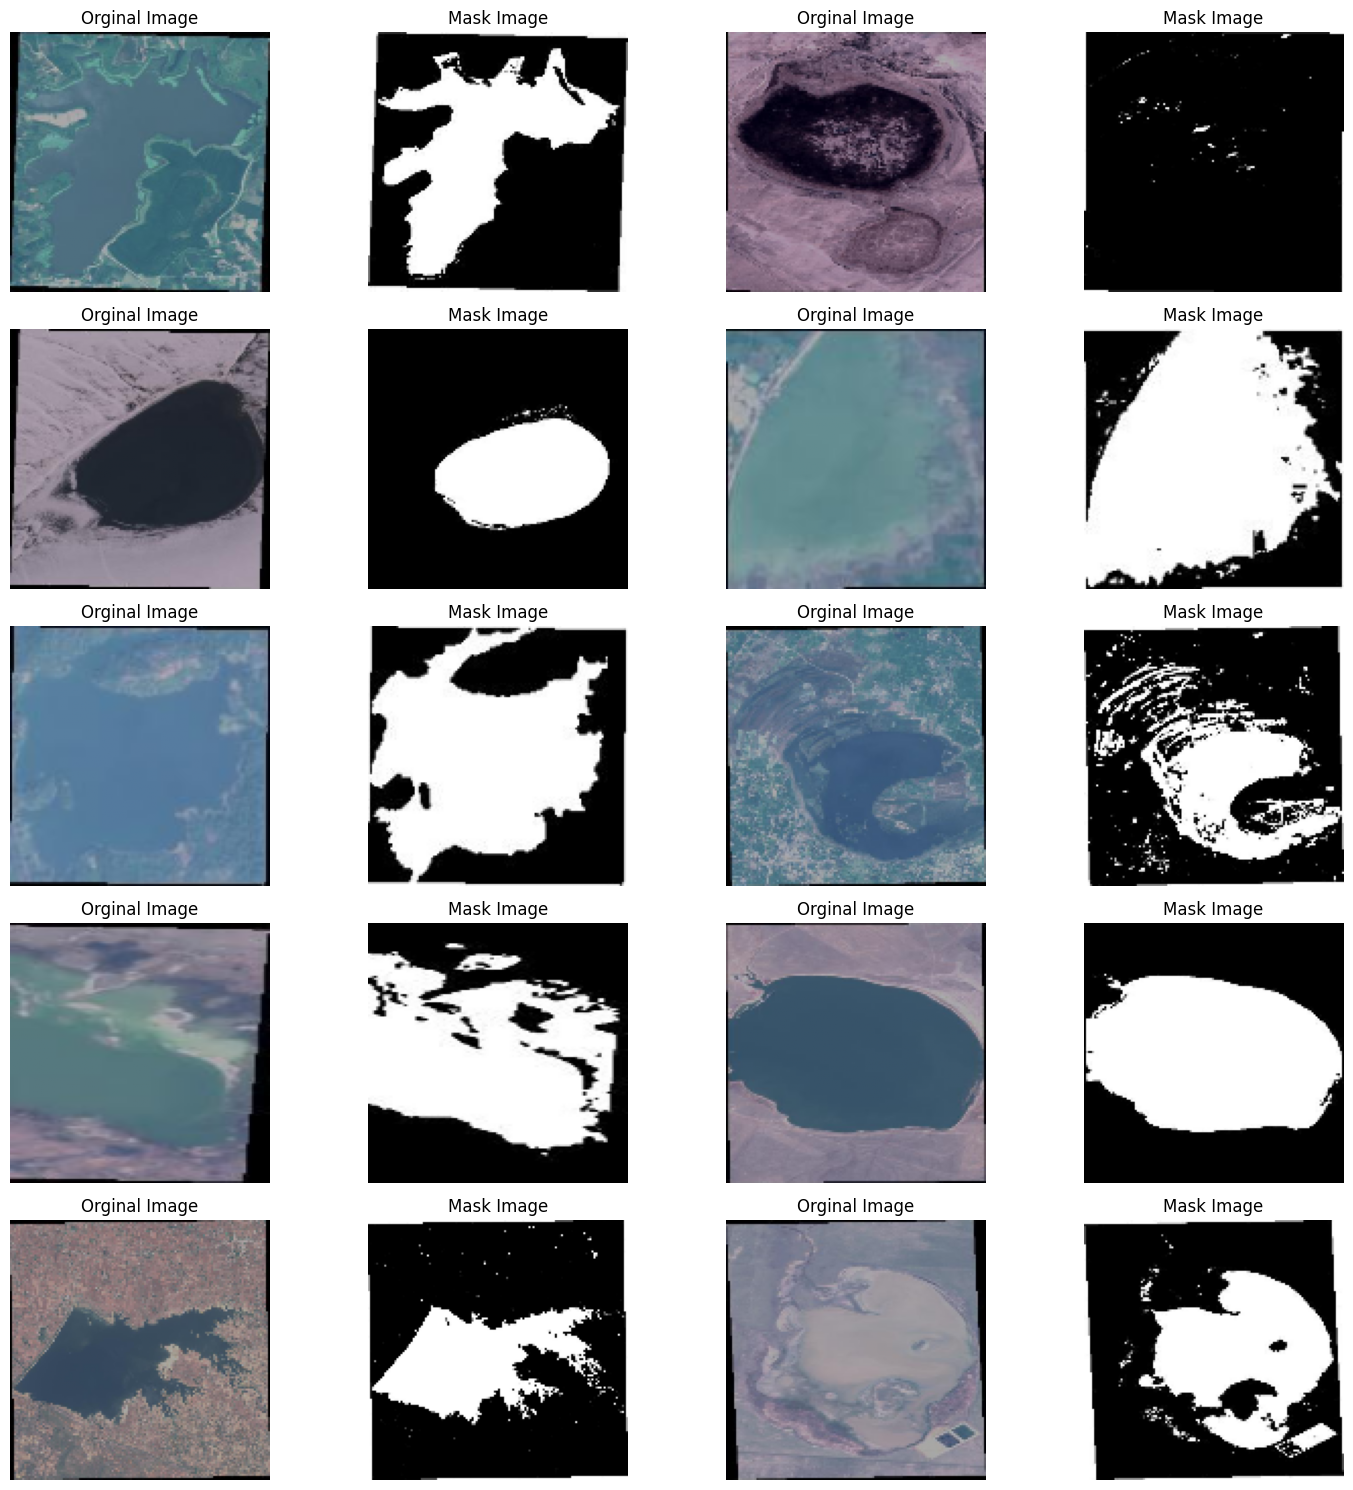

In [5]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

# **U-Net**

## Validation, training and test set split

In [6]:
n_total = len(images)
train_end = int(n_total * 0.7)
val_end = train_end + int(n_total * 0.2)

X_train, y_train = images[:train_end], masks[:train_end]
X_val, y_val = images[train_end:val_end], masks[train_end:val_end]
X_test, y_test = images[val_end:], masks[val_end:]

print(f"Total: {n_total} imágenes y máscaras")
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Prueba: {len(X_test)}")

Total: 2841 imágenes y máscaras
Entrenamiento: 1988
Validación: 568
Prueba: 285


In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1988, 128, 128, 3) (1988, 128, 128, 1)
(568, 128, 128, 3) (568, 128, 128, 1)
(285, 128, 128, 3) (285, 128, 128, 1)


In [8]:
# Evaluar desbalance de clases
foreground_percentage = np.mean(masks > 0)
print(f"Porcentaje de píxeles de objeto (foreground): {foreground_percentage * 100:.2f}%")

Porcentaje de píxeles de objeto (foreground): 45.49%


In [9]:
# Revisar si los valores son 0 y 1
print(np.unique(y_train))
print(np.unique(y_val))

[0.00000000e+00 5.98383885e-08 1.19676777e-07 ... 9.99999880e-01
 9.99999940e-01 1.00000000e+00]
[0.00000000e+00 5.98383885e-08 1.19676777e-07 ... 9.99999820e-01
 9.99999880e-01 1.00000000e+00]


In [10]:
binarize = True

if binarize:
    # binarizar las máscaras para que los valores sean estrictamente 0 o 1???
    y_train = (y_train > 0.5).astype(np.float32)
    y_val = (y_val > 0.5).astype(np.float32)

In [11]:
print(np.unique(y_train))
print(np.unique(y_val))

[0. 1.]
[0. 1.]


I0000 00:00:1735769322.075984   11709 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735769322.159768   11709 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735769322.162270   11709 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735769322.165912   11709 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Usando arquitectura avanzada: unet_efficientnet
Congelando el backbone para unet_efficientnet
Backbone congelado para unet_efficientnet
Entrenando sin Data Augmentation
Epoch 1/10


I0000 00:00:1735769345.428825   11808 service.cc:146] XLA service 0x7f7ee80047b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735769345.428849   11808 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-01-01 19:09:06.120692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-01 19:09:09.030386: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  8/994 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.5655 - dice_coefficient: 0.1524 - loss: 7.2198 - mean_io_u: 0.3284   

I0000 00:00:1735769369.367142   11808 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/steps/step - accuracy: 0.7684 - dice_coefficient: 0.5449 - loss: 1.1881 - mean_io_u: 0.333


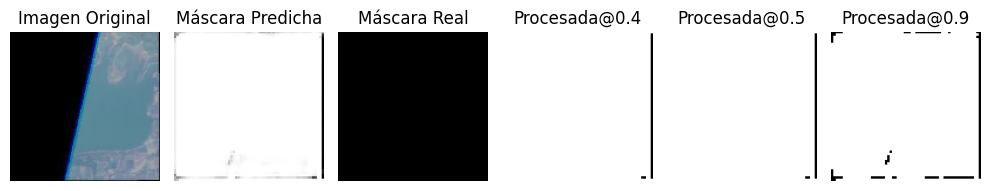

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 1: Mejor Umbral: 0.8, Mejor IoU: 0.2056
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 1: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.1960
994/994 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.7685 - dice_coefficient: 0.5450 - loss: 1.1873 - mean_io_u: 0.3329 - val_accuracy: 0.3445 - val_dice_coefficient: 0.4677 - val_loss: 6.5418 - val_mean_io_u: 0.4610
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.8417 - dice_coefficient: 0.6611 - loss: 0.7281 - mean_io_u: 0.330


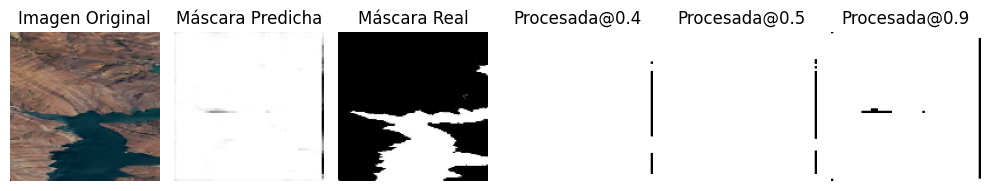

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 2: Mejor Umbral: 0.8, Mejor IoU: 0.1671
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 2: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.1662
994/994 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8417 - dice_coefficient: 0.6611 - loss: 0.7281 - mean_io_u: 0.3302 - val_accuracy: 0.3253 - val_dice_coefficient: 0.4647 - val_loss: 9.7046 - val_mean_io_u: 0.5360
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepstep - accuracy: 0.8632 - dice_coefficient: 0.6920 - loss: 0.6448 - mean_io_u: 0.336


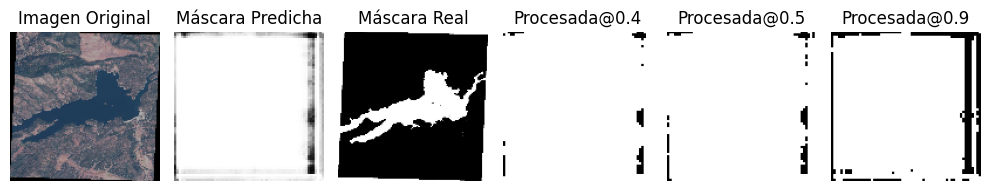

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 3: Mejor Umbral: 0.8, Mejor IoU: 0.2122
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 3: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.2000
994/994 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8631 - dice_coefficient: 0.6920 - loss: 0.6449 - mean_io_u: 0.3363 - val_accuracy: 0.3464 - val_dice_coefficient: 0.4658 - val_loss: 4.7941 - val_mean_io_u: 0.3378
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - accuracy: 0.8686 - dice_coefficient: 0.7203 - loss: 0.6128 - mean_io_u: 0.331


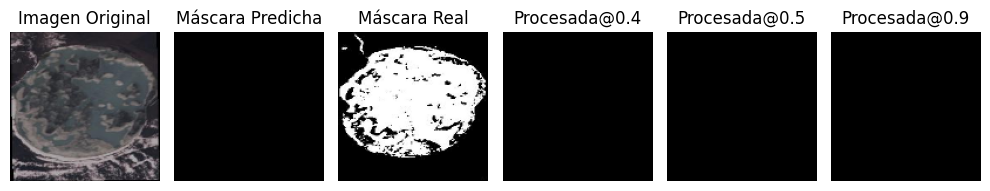

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 4: Mejor Umbral: 0.1, Mejor IoU: 0.1623
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 4: Mejor Umbral: 0.3, Mejor IoU: 0.1623
994/994 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8686 - dice_coefficient: 0.7203 - loss: 0.6129 - mean_io_u: 0.3311 - val_accuracy: 0.3245 - val_dice_coefficient: 0.4693 - val_loss: 161.9853 - val_mean_io_u: 0.1623
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.8642 - dice_coefficient: 0.7078 - loss: 0.6307 - mean_io_u: 0.334


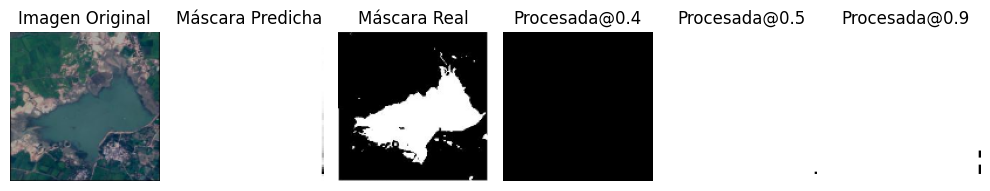

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 5: Mejor Umbral: 0.8, Mejor IoU: 0.1628
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 5: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.1627
994/994 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8642 - dice_coefficient: 0.7079 - loss: 0.6306 - mean_io_u: 0.3345 - val_accuracy: 0.3248 - val_dice_coefficient: 0.4690 - val_loss: 21.0408 - val_mean_io_u: 0.1689
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - accuracy: 0.8789 - dice_coefficient: 0.7307 - loss: 0.5716 - mean_io_u: 0.330


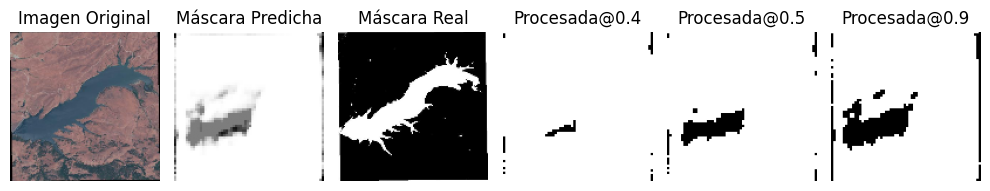

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 6: Mejor Umbral: 0.8, Mejor IoU: 0.2048
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 6: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.2012
994/994 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8789 - dice_coefficient: 0.7307 - loss: 0.5716 - mean_io_u: 0.3307 - val_accuracy: 0.3397 - val_dice_coefficient: 0.4256 - val_loss: 7.7313 - val_mean_io_u: 0.3415
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/stepstep - accuracy: 0.8803 - dice_coefficient: 0.7265 - loss: 0.5750 - mean_io_u: 0.337


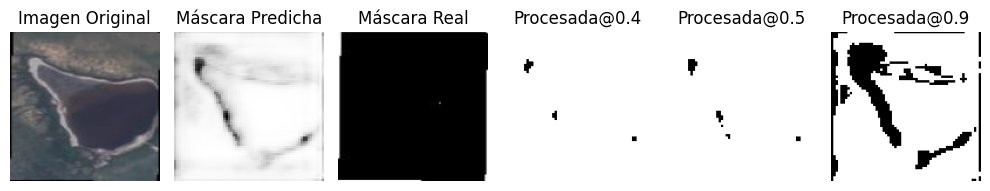

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 7: Mejor Umbral: 0.8, Mejor IoU: 0.2231
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 7: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.1899
994/994 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8803 - dice_coefficient: 0.7265 - loss: 0.5749 - mean_io_u: 0.3371 - val_accuracy: 0.3329 - val_dice_coefficient: 0.4745 - val_loss: 2.3961 - val_mean_io_u: 0.3378
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - accuracy: 0.8895 - dice_coefficient: 0.7515 - loss: 0.5347 - mean_io_u: 0.333


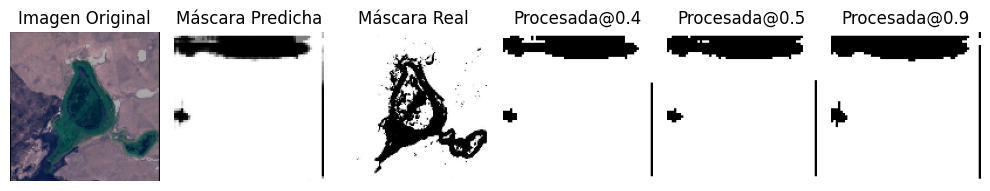

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 8: Mejor Umbral: 0.8, Mejor IoU: 0.2484
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 8: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.2465
994/994 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8895 - dice_coefficient: 0.7515 - loss: 0.5347 - mean_io_u: 0.3329 - val_accuracy: 0.4042 - val_dice_coefficient: 0.4742 - val_loss: 10.6835 - val_mean_io_u: 0.3742
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepstep - accuracy: 0.8887 - dice_coefficient: 0.7528 - loss: 0.5339 - mean_io_u: 0.329


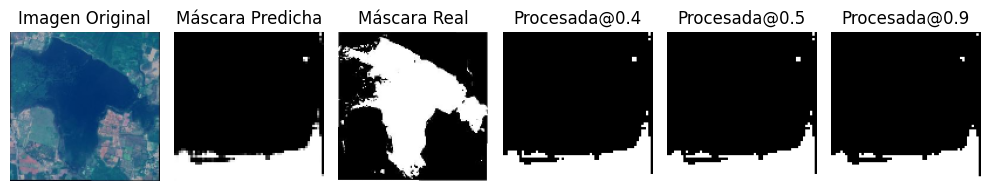

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 9: Mejor Umbral: 0.8, Mejor IoU: 0.3122
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 9: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.3119
994/994 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8887 - dice_coefficient: 0.7528 - loss: 0.5340 - mean_io_u: 0.3298 - val_accuracy: 0.5381 - val_dice_coefficient: 0.1902 - val_loss: 21.3154 - val_mean_io_u: 0.3163
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.8937 - dice_coefficient: 0.7517 - loss: 0.5247 - mean_io_u: 0.336


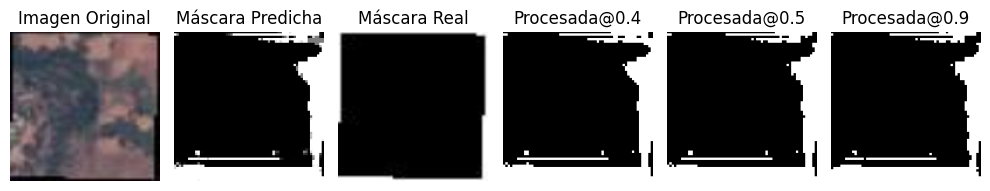

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 10: Mejor Umbral: 0.8, Mejor IoU: 0.3203
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 10: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.3200
994/994 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8937 - dice_coefficient: 0.7517 - loss: 0.5247 - mean_io_u: 0.3362 - val_accuracy: 0.5630 - val_dice_coefficient: 0.1681 - val_loss: 53.0716 - val_mean_io_u: 0.3304
Realizando ajuste fino
Ajuste fino sin Data Augmentation
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/step - accuracy: 0.8980 - dice_coefficient: 0.7709 - loss: 0.4879 - mean_io_u_131: 0.330


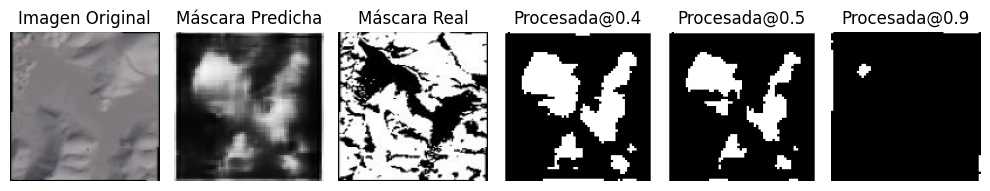

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Época 1: Mejor Umbral: 0.5, Mejor IoU: 0.7778
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Época 1: Mejor Umbral: 0.5, Mejor IoU: 0.7778
994/994 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step - accuracy: 0.8980 - dice_coefficient: 0.7709 - loss: 0.4880 - mean_io_u_131: 0.3301 - val_accuracy: 0.8905 - val_dice_coefficient: 0.7526 - val_loss: 0.5437 - val_mean_io_u_131: 0.3388
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/stepstep - accuracy: 0.8978 - dice_coefficient: 0.7667 - loss: 0.4961 - mean_io_u_131: 0.331


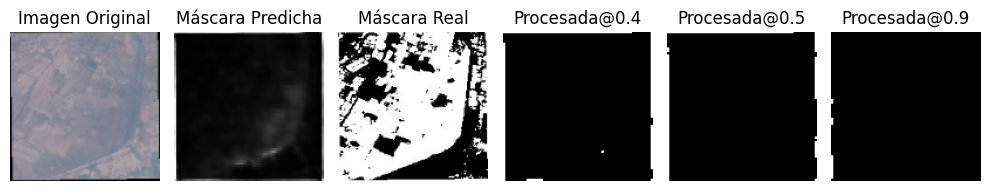

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 2: Mejor Umbral: 0.4, Mejor IoU: 0.7689
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 2: Mejor Umbral: 0.4, Mejor IoU: 0.7689
994/994 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8978 - dice_coefficient: 0.7667 - loss: 0.4961 - mean_io_u_131: 0.3317 - val_accuracy: 0.8863 - val_dice_coefficient: 0.7403 - val_loss: 0.5674 - val_mean_io_u_131: 0.3380
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.8991 - dice_coefficient: 0.7740 - loss: 0.4847 - mean_io_u_131: 0.328


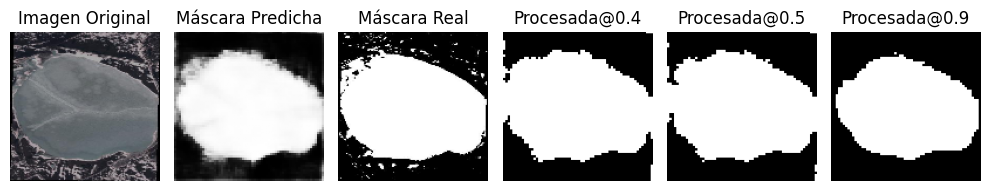

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 3: Mejor Umbral: 0.4, Mejor IoU: 0.7603
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 3: Mejor Umbral: 0.4, Mejor IoU: 0.7603
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8991 - dice_coefficient: 0.7740 - loss: 0.4847 - mean_io_u_131: 0.3280 - val_accuracy: 0.8806 - val_dice_coefficient: 0.7381 - val_loss: 0.5795 - val_mean_io_u_131: 0.3382
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.8994 - dice_coefficient: 0.7680 - loss: 0.4944 - mean_io_u_131: 0.331


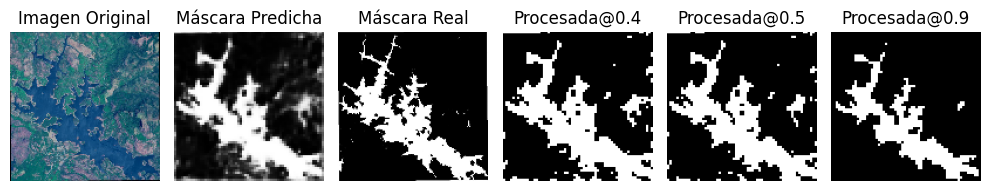

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 4: Mejor Umbral: 0.5, Mejor IoU: 0.7772
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 4: Mejor Umbral: 0.5, Mejor IoU: 0.7772
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8994 - dice_coefficient: 0.7680 - loss: 0.4944 - mean_io_u_131: 0.3310 - val_accuracy: 0.8895 - val_dice_coefficient: 0.7581 - val_loss: 0.5444 - val_mean_io_u_131: 0.3389
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.9014 - dice_coefficient: 0.7786 - loss: 0.4768 - mean_io_u_131: 0.329


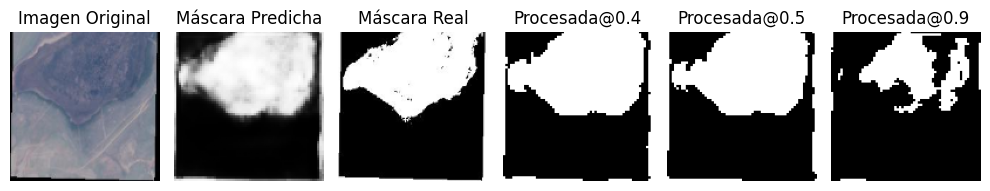

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 5: Mejor Umbral: 0.7000000000000001, Mejor IoU: 0.7523
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 5: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.7523
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9014 - dice_coefficient: 0.7786 - loss: 0.4768 - mean_io_u_131: 0.3299 - val_accuracy: 0.8665 - val_dice_coefficient: 0.7396 - val_loss: 0.6192 - val_mean_io_u_131: 0.3382
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepstep - accuracy: 0.9027 - dice_coefficient: 0.7747 - loss: 0.4777 - mean_io_u_131: 0.333


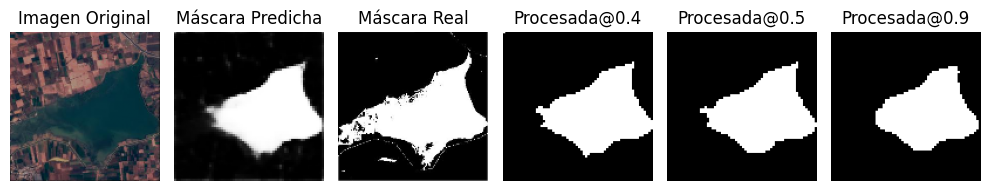

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 6: Mejor Umbral: 0.6, Mejor IoU: 0.7661
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 6: Mejor Umbral: 0.6000000000000001, Mejor IoU: 0.7661
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9027 - dice_coefficient: 0.7747 - loss: 0.4777 - mean_io_u_131: 0.3336 - val_accuracy: 0.8810 - val_dice_coefficient: 0.7502 - val_loss: 0.5736 - val_mean_io_u_131: 0.3391
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/stepstep - accuracy: 0.9023 - dice_coefficient: 0.7708 - loss: 0.4809 - mean_io_u_131: 0.331


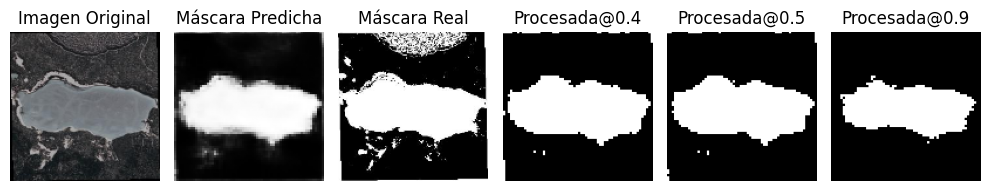

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 7: Mejor Umbral: 0.5, Mejor IoU: 0.7624
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 7: Mejor Umbral: 0.5, Mejor IoU: 0.7624
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9023 - dice_coefficient: 0.7708 - loss: 0.4809 - mean_io_u_131: 0.3310 - val_accuracy: 0.8822 - val_dice_coefficient: 0.7407 - val_loss: 0.5790 - val_mean_io_u_131: 0.3383
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.9039 - dice_coefficient: 0.7719 - loss: 0.4819 - mean_io_u_131: 0.334


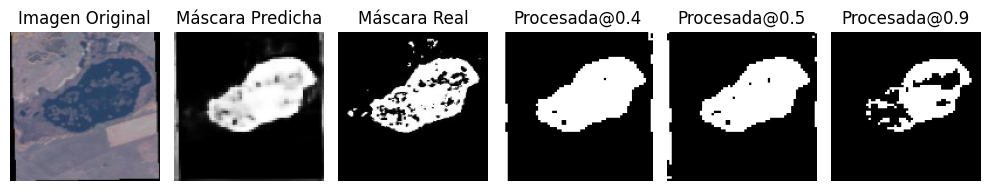

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 8: Mejor Umbral: 0.4, Mejor IoU: 0.7535
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 8: Mejor Umbral: 0.4, Mejor IoU: 0.7535
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9039 - dice_coefficient: 0.7719 - loss: 0.4819 - mean_io_u_131: 0.3338 - val_accuracy: 0.8770 - val_dice_coefficient: 0.7320 - val_loss: 0.6006 - val_mean_io_u_131: 0.3382
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.9074 - dice_coefficient: 0.7849 - loss: 0.4562 - mean_io_u_131: 0.330


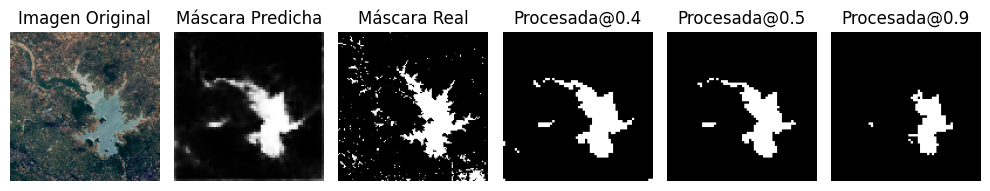

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 9: Mejor Umbral: 0.5, Mejor IoU: 0.7797
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 9: Mejor Umbral: 0.5, Mejor IoU: 0.7797
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9074 - dice_coefficient: 0.7849 - loss: 0.4562 - mean_io_u_131: 0.3303 - val_accuracy: 0.8917 - val_dice_coefficient: 0.7572 - val_loss: 0.5373 - val_mean_io_u_131: 0.3385
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepstep - accuracy: 0.9034 - dice_coefficient: 0.7741 - loss: 0.4750 - mean_io_u_131: 0.332


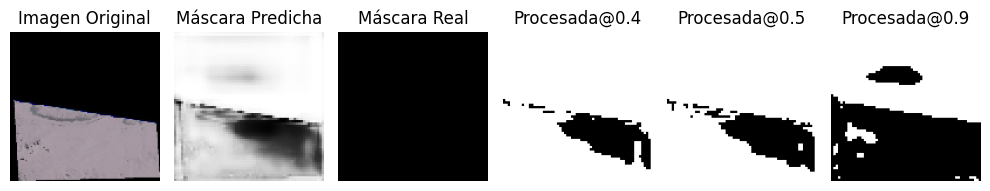

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 10: Mejor Umbral: 0.5, Mejor IoU: 0.7740
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 10: Mejor Umbral: 0.5, Mejor IoU: 0.7740
994/994 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9034 - dice_coefficient: 0.7741 - loss: 0.4750 - mean_io_u_131: 0.3326 - val_accuracy: 0.8882 - val_dice_coefficient: 0.7530 - val_loss: 0.5520 - val_mean_io_u_131: 0.3385
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepstep - accuracy: 0.9055 - dice_coefficient: 0.7778 - loss: 0.4664 - mean_io_u_131: 0.331


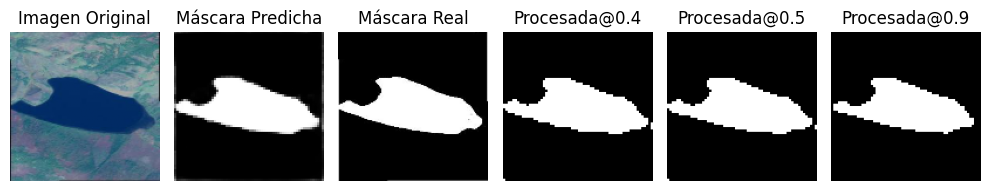

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Época 11: Mejor Umbral: 0.4, Mejor IoU: 0.7784
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Época 11: Mejor Umbral: 0.4, Mejor IoU: 0.7784
994/994 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9055 - dice_coefficient: 0.7778 - loss: 0.4664 - mean_io_u_131: 0.3312 - val_accuracy: 0.8909 - val_dice_coefficient: 0.7504 - val_loss: 0.5430 - val_mean_io_u_131: 0.3379
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.9055 - dice_coefficient: 0.7790 - loss: 0.4654 - mean_io_u_131: 0.334


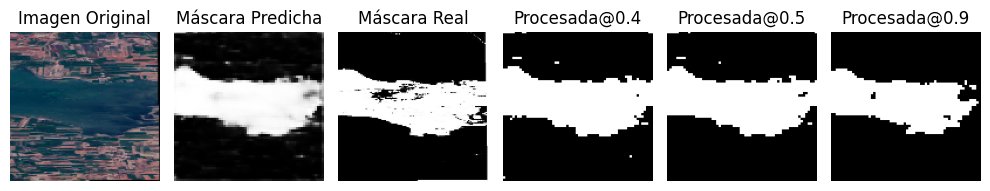

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Época 12: Mejor Umbral: 0.4, Mejor IoU: 0.7746
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 12: Mejor Umbral: 0.4, Mejor IoU: 0.7746
994/994 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9055 - dice_coefficient: 0.7790 - loss: 0.4655 - mean_io_u_131: 0.3343 - val_accuracy: 0.8888 - val_dice_coefficient: 0.7537 - val_loss: 0.5488 - val_mean_io_u_131: 0.3391
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepstep - accuracy: 0.9051 - dice_coefficient: 0.7799 - loss: 0.4647 - mean_io_u_131: 0.332


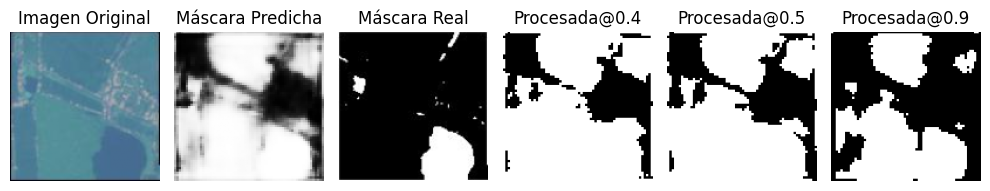

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 13: Mejor Umbral: 0.5, Mejor IoU: 0.7605
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Época 13: Mejor Umbral: 0.5, Mejor IoU: 0.7605
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9051 - dice_coefficient: 0.7799 - loss: 0.4647 - mean_io_u_131: 0.3327 - val_accuracy: 0.8805 - val_dice_coefficient: 0.7414 - val_loss: 0.5809 - val_mean_io_u_131: 0.3383
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/stepstep - accuracy: 0.9080 - dice_coefficient: 0.7851 - loss: 0.4526 - mean_io_u_131: 0.333


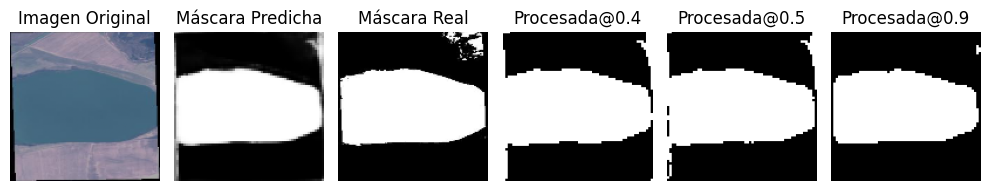

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 14: Mejor Umbral: 0.6, Mejor IoU: 0.7660
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 14: Mejor Umbral: 0.6000000000000001, Mejor IoU: 0.7660
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9080 - dice_coefficient: 0.7851 - loss: 0.4526 - mean_io_u_131: 0.3336 - val_accuracy: 0.8823 - val_dice_coefficient: 0.7526 - val_loss: 0.5693 - val_mean_io_u_131: 0.3385
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/stepstep - accuracy: 0.9096 - dice_coefficient: 0.7882 - loss: 0.4459 - mean_io_u_131: 0.334


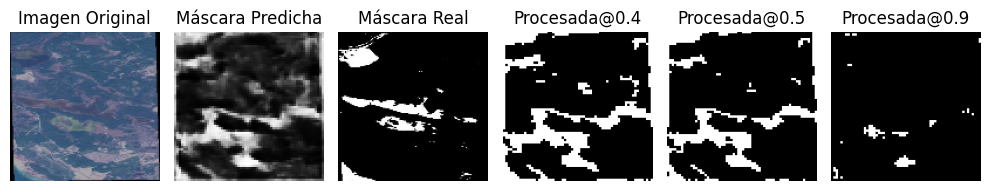

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 15: Mejor Umbral: 0.5, Mejor IoU: 0.7633
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 15: Mejor Umbral: 0.5, Mejor IoU: 0.7633
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9095 - dice_coefficient: 0.7882 - loss: 0.4459 - mean_io_u_131: 0.3341 - val_accuracy: 0.8809 - val_dice_coefficient: 0.7482 - val_loss: 0.5774 - val_mean_io_u_131: 0.3383
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.9064 - dice_coefficient: 0.7923 - loss: 0.4504 - mean_io_u_131: 0.328


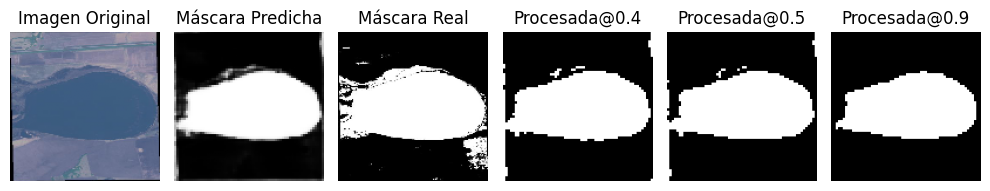

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 16: Mejor Umbral: 0.5, Mejor IoU: 0.7754
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 16: Mejor Umbral: 0.5, Mejor IoU: 0.7754
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9064 - dice_coefficient: 0.7923 - loss: 0.4504 - mean_io_u_131: 0.3285 - val_accuracy: 0.8890 - val_dice_coefficient: 0.7558 - val_loss: 0.5456 - val_mean_io_u_131: 0.3379
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepstep - accuracy: 0.9068 - dice_coefficient: 0.7848 - loss: 0.4594 - mean_io_u_131: 0.330


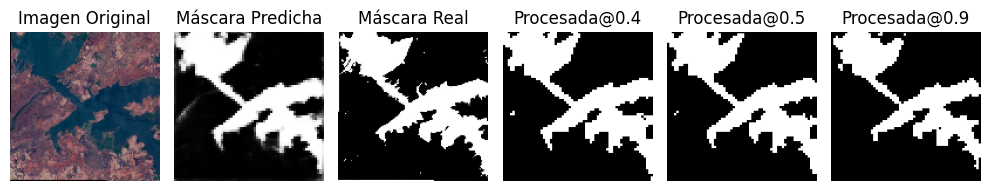

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 17: Mejor Umbral: 0.6, Mejor IoU: 0.7487
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 17: Mejor Umbral: 0.6000000000000001, Mejor IoU: 0.7487
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9068 - dice_coefficient: 0.7847 - loss: 0.4594 - mean_io_u_131: 0.3304 - val_accuracy: 0.8713 - val_dice_coefficient: 0.7387 - val_loss: 0.6162 - val_mean_io_u_131: 0.3382
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepstep - accuracy: 0.9113 - dice_coefficient: 0.7799 - loss: 0.4521 - mean_io_u_131: 0.334


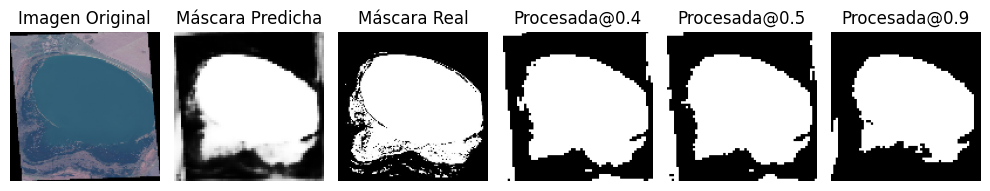

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 18: Mejor Umbral: 0.8, Mejor IoU: 0.7531
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 18: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.7524
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9113 - dice_coefficient: 0.7800 - loss: 0.4521 - mean_io_u_131: 0.3344 - val_accuracy: 0.8643 - val_dice_coefficient: 0.7452 - val_loss: 0.6254 - val_mean_io_u_131: 0.3381
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/stepstep - accuracy: 0.9043 - dice_coefficient: 0.7667 - loss: 0.4802 - mean_io_u_131: 0.334


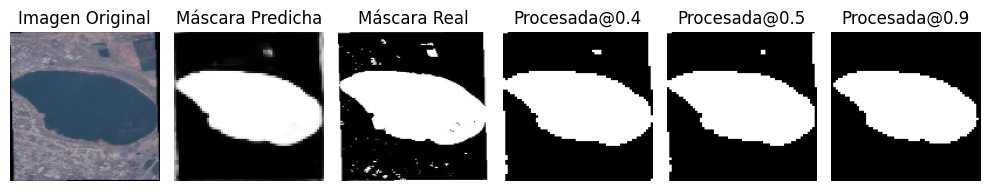

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 19: Mejor Umbral: 0.7000000000000001, Mejor IoU: 0.7629
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Época 19: Mejor Umbral: 0.7000000000000002, Mejor IoU: 0.7629
994/994 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9043 - dice_coefficient: 0.7667 - loss: 0.4802 - mean_io_u_131: 0.3345 - val_accuracy: 0.8775 - val_dice_coefficient: 0.7543 - val_loss: 0.5815 - val_mean_io_u_131: 0.3380


In [12]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from utils import (
    unet, unet_plus_plus, fpn, unet_efficientnet, segformer, dice_coefficient,
    iou_loss, weighted_binary_crossentropy, combined_loss, dice_loss, focal_tversky_loss,
    ShowProgress, DynamicThresholdCallback, BestIoUCallback,
    get_image_data_generator, create_albumentations_augmentations, albumentations_data_generator, val_generator
)

# --- Configuraciones ---
# Arquitectura
use_advanced_architecture = True  # True para arquitecturas avanzadas, False para simples
use_unet_plus_plus = False  # True para U-Net++, False para U-Net (si se usan arquitecturas simples)
selected_advanced_architecture = 'unet_efficientnet'  # Cambiar entre 'unet_efficientnet', 'fpn' or 'segformer'

# Aumentación
use_augmentation = False  # True para usar aumentación, False para no usarla
augmentation_method = "albumentations"  # Alternativas: "image_data_generator"/"albumentations"

# Hiperparámetros
batch_size = 2
initial_epochs = 10
fine_tune_epochs = 20
learning_rate = 1e-3

# --- Función de pérdida ---
loss_funcs = {
    'iou_loss': iou_loss,
    'dice_loss': dice_loss,
    'combined_loss': combined_loss,  # Dice + IoU
    'focal_tversky_loss': focal_tversky_loss,
    'binary_crossentropy': 'binary_crossentropy',
    'weighted_binary_crossentropy': weighted_binary_crossentropy
}
loss_func = loss_funcs['combined_loss']

# --- Optimización y Callbacks ---
use_lr_schedule = True  # Cambiar entre usar learning rate scheduling o no

if use_lr_schedule:
    # Learning Rate Scheduling
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
    )
    optimizers = {
        'SGD': tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
        'Adam': tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        'AdamW': tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
    }
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint('UNet.keras', save_best_only=True),
        ShowProgress(images=images, masks=masks, save=True),
        DynamicThresholdCallback(X_val=X_val, y_val=y_val),
        BestIoUCallback(validation_data=(X_val, y_val))
    ]
else:
    # Sin Learning Rate Scheduling
    optimizers = {
        'SGD': tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
        'Adam': tf.keras.optimizers.Adam(learning_rate=1e-4),
        'AdamW': tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
    }
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint('UNet.keras', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        ShowProgress(images=images, masks=masks, save=True),
        DynamicThresholdCallback(X_val=X_val, y_val=y_val),
        BestIoUCallback(validation_data=(X_val, y_val))
    ]

# Seleccionar el optimizador
optimizer = optimizers['AdamW']

# --- Selección de Arquitectura ---
if use_advanced_architecture:
    print("Usando arquitectura avanzada:", selected_advanced_architecture)
    advanced_architectures = {
        'fpn': fpn(input_size=(128, 128, 3), num_classes=1),
        'unet_efficientnet': unet_efficientnet(input_size=(128, 128, 3), num_classes=1),
        'segformer': segformer(input_size=(128, 128, 3), num_classes=1)
    }
    model = advanced_architectures[selected_advanced_architecture]
else:
    if use_unet_plus_plus:
        print("Usando arquitectura simple: U-Net++")
        model = unet_plus_plus(input_size=(128, 128, 3), num_classes=1)
    else:
        print("Usando arquitectura simple: U-Net")
        model = unet(input_size=(128, 128, 3), num_classes=1)

# Congelar el backbone si es una arquitectura avanzada
if use_advanced_architecture:
    print(f"Congelando el backbone para {selected_advanced_architecture}")

    if selected_advanced_architecture == 'unet_efficientnet':
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True  # Mantener BatchNormalization entrenable
            elif 'efficientnet' in layer.name:
                layer.trainable = False

    elif selected_advanced_architecture == 'segformer':
        for layer in model.layers:
            if 'transformer' in layer.name or 'segformer' in layer.name:  # Ajusta según el backbone
                layer.trainable = False
            elif isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

    elif selected_advanced_architecture == 'deeplabv3plus':
        for layer in model.layers:
            if 'resnet' in layer.name or 'xception' in layer.name or 'efficientnet' in layer.name:
                layer.trainable = False
            elif isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

    elif selected_advanced_architecture == 'fpn':
        for layer in model.layers:
            if 'resnet' in layer.name:  # Suponiendo que FPN usa ResNet como backbone
                layer.trainable = False
            elif isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

    print(f"Backbone congelado para {selected_advanced_architecture}")

# Compilar el modelo
model.compile(
    loss=loss_func,
    optimizer=optimizer,
    metrics=['accuracy', dice_coefficient, MeanIoU(num_classes=2)]
)

# --- Aumentación ---
if use_augmentation:
    print("Entrenando con Data Augmentation:", augmentation_method)
    if augmentation_method == "image_data_generator":
        datagen = get_image_data_generator()
        train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
        val_data = (X_val, y_val)
    elif augmentation_method == "albumentations":
        augmentation = create_albumentations_augmentations()
        train_generator = albumentations_data_generator(X_train, y_train, batch_size, augmentation)
        val_data = val_generator(X_val, y_val, batch_size)

    # Entrenamiento con Data Augmentation
    history = model.fit(
        train_generator,
        validation_data=val_data,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_val) // batch_size,
        epochs=initial_epochs,
        callbacks=callbacks,
        verbose=1
    )
else:
    print("Entrenando sin Data Augmentation")
    # Entrenamiento directo sin generador
    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=initial_epochs,
        callbacks=callbacks,
        verbose=1
    )


# --- Fine-Tuning ---
if use_advanced_architecture:
    print("Realizando ajuste fino")
    
    # Descongelar todas las capas del modelo
    for layer in model.layers:
        layer.trainable = True  

    # Configurar el optimizador para el ajuste fino
    fine_tune_optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)

    # Compilar nuevamente el modelo
    model.compile(
        loss=loss_func,
        optimizer=fine_tune_optimizer,
        metrics=['accuracy', dice_coefficient, MeanIoU(num_classes=2)]
    )

    # Entrenamiento con ajuste fino
    if use_augmentation:
        print("Ajuste fino con Data Augmentation:", augmentation_method)
        fine_tune_history = model.fit(
            train_generator,
            validation_data=val_data,
            steps_per_epoch=len(X_train) // batch_size,
            validation_steps=len(X_val) // batch_size,
            epochs=fine_tune_epochs,
            callbacks=callbacks,
            verbose=1
        )
    else:
        print("Ajuste fino sin Data Augmentation")
        fine_tune_history = model.fit(
            x=X_train,
            y=y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=fine_tune_epochs,
            callbacks=callbacks,
            verbose=1
        )



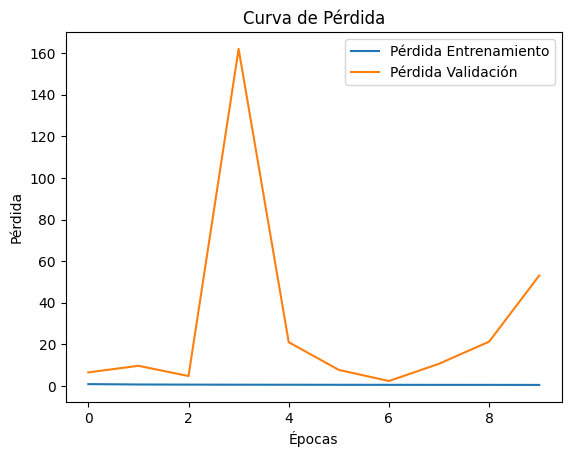

In [13]:
# Graficar pérdida
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida')
plt.show()

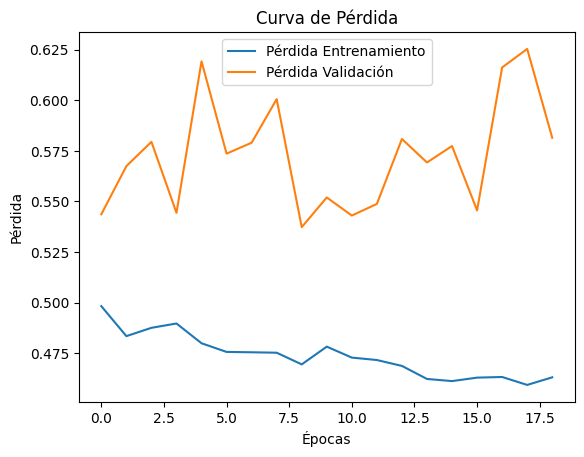

In [14]:
if use_advanced_architecture:
    # Graficar pérdida
    plt.plot(fine_tune_history.history['loss'], label='Pérdida Entrenamiento')
    plt.plot(fine_tune_history.history['val_loss'], label='Pérdida Validación')
    plt.legend()
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Curva de Pérdida')
    plt.show()

In [15]:
# Obtener predicciones del modelo
y_test_pred = model.predict(X_test)

# Probar diferentes umbrales
thresholds = np.arange(0.3, 0.8, 0.1)
best_threshold = 0.5  # Inicialmente
best_iou = 0  # Para rastrear el mejor IoU

for t in thresholds:
    pred_binary = (y_test_pred > t).astype(np.int32)  # Binarizar las predicciones
    iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)  # Crear métrica de IoU
    iou_metric.update_state(y_test.flatten(), pred_binary.flatten())  # Actualizar con datos
    iou_score = iou_metric.result().numpy()  # Calcular IoU
    print(f"Threshold: {t}, IoU: {iou_score:.4f}")
    if iou_score > best_iou:
        best_iou = iou_score
        best_threshold = t

print(f"Mejor umbral: {best_threshold}, Mejor IoU: {best_iou:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step
Threshold: 0.3, IoU: 0.6956
Threshold: 0.4, IoU: 0.7147
Threshold: 0.5, IoU: 0.7308
Threshold: 0.6000000000000001, IoU: 0.7456
Threshold: 0.7000000000000002, IoU: 0.7611
Mejor umbral: 0.7000000000000002, Mejor IoU: 0.7611


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


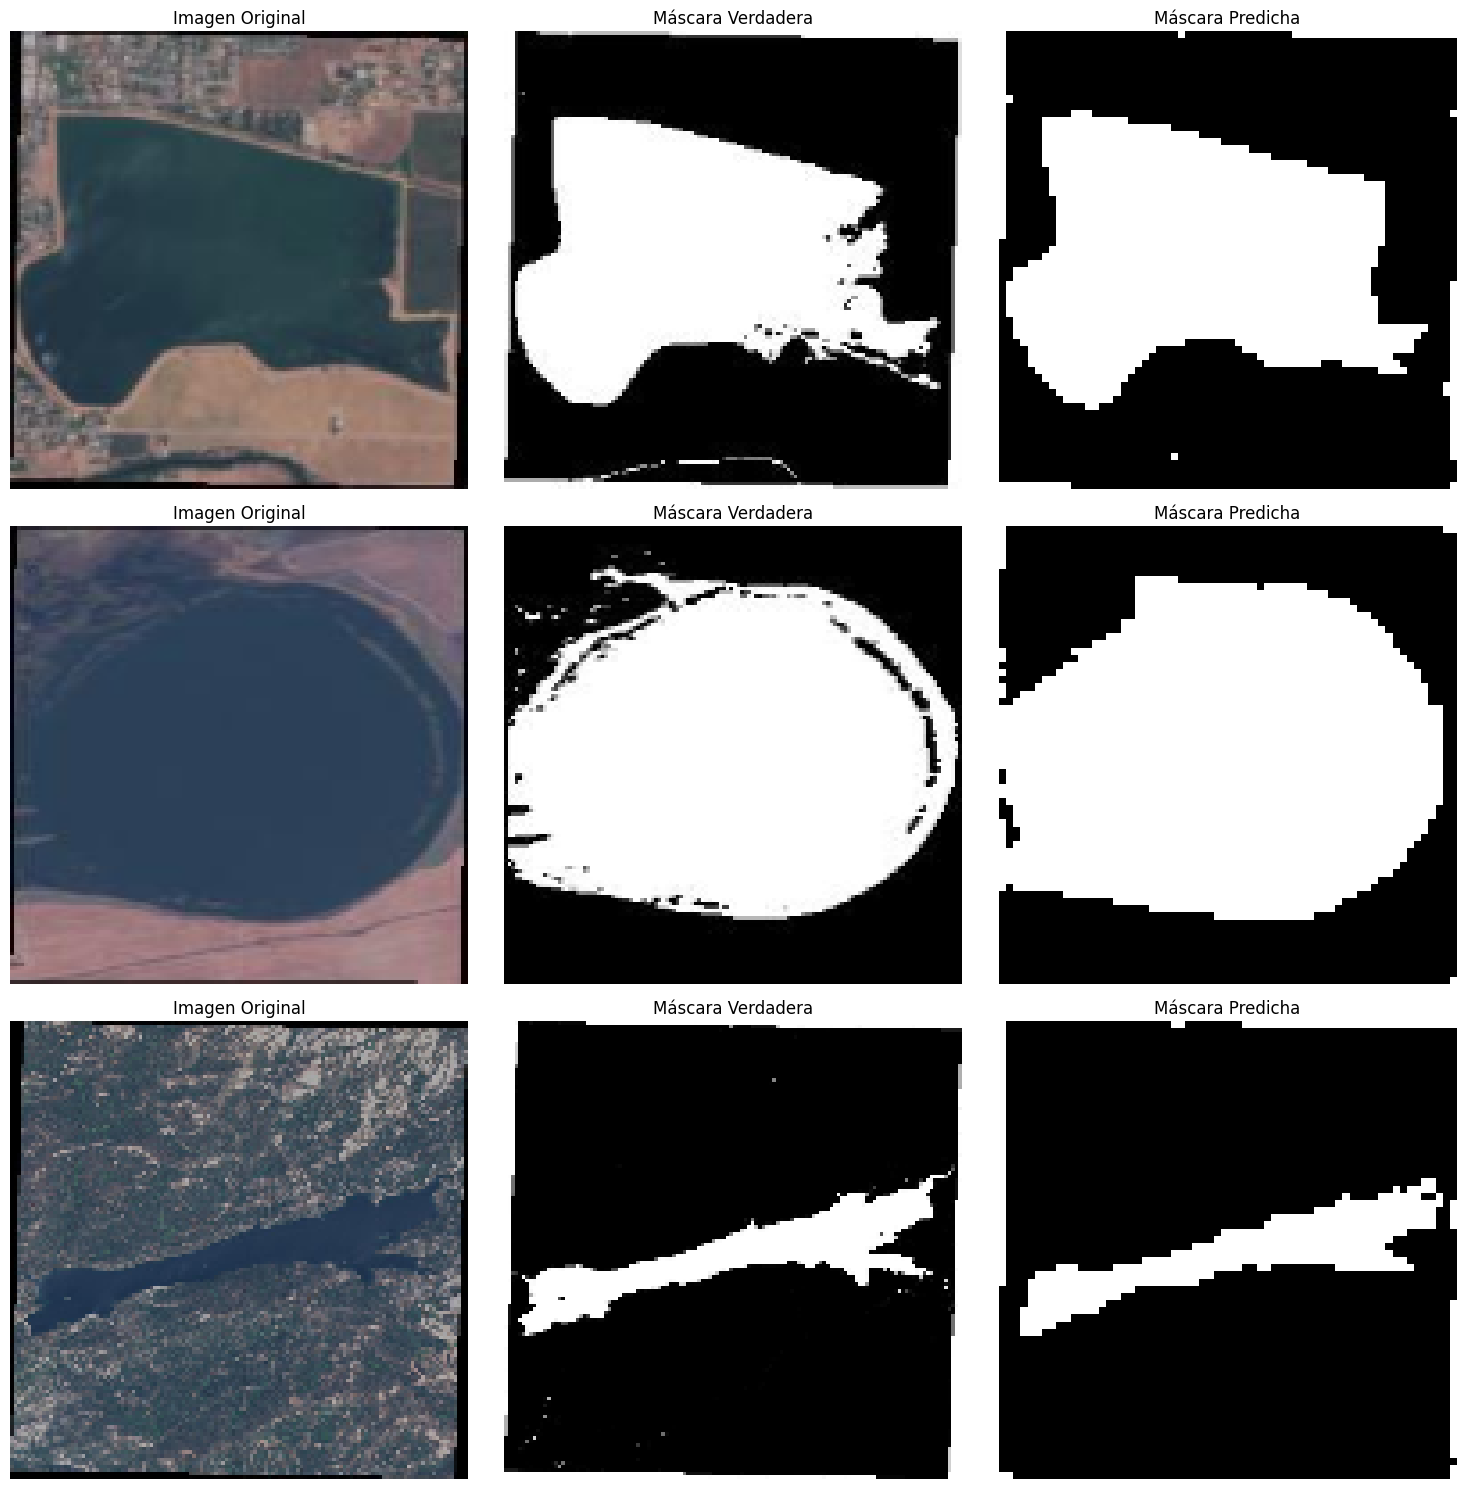

In [16]:
random_indices = np.random.choice(len(X_test), 3, replace=False)
plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    test_image = X_test[idx]
    true_mask = y_test[idx].reshape(SIZE, SIZE)
    pred_mask = model.predict(test_image[np.newaxis, ...])[0] # predecir
    pred_mask = pred_mask.reshape(SIZE, SIZE) > 0.5  # Umbral para binarizar

    # imagen original
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(test_image)
    plt.title("Imagen Original")
    plt.axis("off")

    # mascara verdadera
    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Máscara Verdadera")
    plt.axis("off")

    # mascara predicha
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Máscara Predicha")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [17]:
# Evaluar el modelo en el conjunto de test
print("Evaluando el modelo en el conjunto de test...")
y_test_pred = model.predict(X_test, batch_size=16)  # Realizar predicciones
y_test_pred_binary = (y_test_pred > 0.5).astype(np.int32)  # Binarizar las predicciones (umbral 0.5)

# Calcular MeanIoU
iou_metric = MeanIoU(num_classes=2)  # Configurar la métrica para segmentación binaria
iou_metric.update_state(y_test.flatten(), y_test_pred_binary.flatten())  # Actualizar con los datos
iou_score = iou_metric.result().numpy()  # Calcular el IoU
print(f"Mean IoU en el conjunto de test: {iou_score:.4f}")

Evaluando el modelo en el conjunto de test...
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step
Mean IoU en el conjunto de test: 0.7308
